In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from utils.matrix import project_points, select_points_within_bounds
from utils.colmap_data import COLMAP_Data
from utils.plot_utils import create_ellipsoids_as_one_mesh
from src.gaussian import GaussianSplatting

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
colmap_data = COLMAP_Data("data/sparse/0")
model = GaussianSplatting(colmap_data)
sigmas = model.init_gaussian_covariance()

(56042, 3)


In [16]:
colmap_data.frame_names[1]

'frame_00001.png'

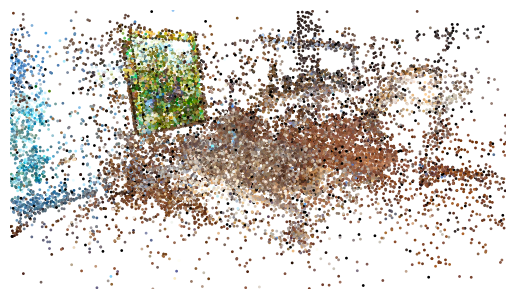

In [15]:
e = colmap_data.W2C[colmap_data.frame_names[1]]
projected_points, projected_depths = project_points(colmap_data.points, e, colmap_data.K, return_depth=True)
bound_indices = (projected_points >= 0).all(axis=1) & (projected_points < [colmap_data.width, colmap_data.height]).all(axis=1)

bounded_points = projected_points[bound_indices]
bounded_colors = colmap_data.colors[bound_indices]
bounded_depths = projected_depths[bound_indices]

plt.scatter(bounded_points[:, 0], bounded_points[:, 1], c=bounded_colors, s=1)
plt.xlim(0, colmap_data.width)
plt.ylim(colmap_data.height, 0)  # Invert y-axis to match image coordinates
plt.gca().set_aspect('equal')
plt.axis('off')
plt.savefig('docs/images/projected_frame_00001.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [14]:
# Visualize covariance
viz_sigmas = sigmas * 0.1
big_mesh = create_ellipsoids_as_one_mesh(model.points, viz_sigmas, model.colors, sphere_resolution=10)
o3d.visualization.draw_geometries([big_mesh])

In [17]:
"""
project covariance to image space

sigma` = JW Sigma W^T J^T

J = [[fx/z, 0, -fx*x/(z^2)]
    [0, fy/z, -fy*y/(z^2)]]
"""


E = colmap_data.W2C[colmap_data.frame_names[1]]
K = colmap_data.K
distortion = colmap_data.distortion
points = colmap_data.points

In [18]:
from utils.matrix import project_covariance
sigma_2d = project_covariance(points, sigmas, E, K)
bound_sigmas_2d = sigma_2d[bound_indices]

In [19]:
from matplotlib.patches import Ellipse
import numpy as np

eigenvals, eigenvecs = np.linalg.eigh(bound_sigmas_2d)

def plot_cov_ellipse(i, cov, mean, ax, n_std=1.0, **kwargs):
    # Angle between largest eigenvector and x-axis
    angle = np.degrees(np.arctan2(eigenvecs[i][1, 0], eigenvecs[i][0, 0]))
    
    # Width and height are 2*n_std*sqrt(eigenvalues)
    # for anisotropic covariance, modify this
    width, height = 2 * n_std * np.sqrt(eigenvals[i])
    
    ellip = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellip)
    return ellip

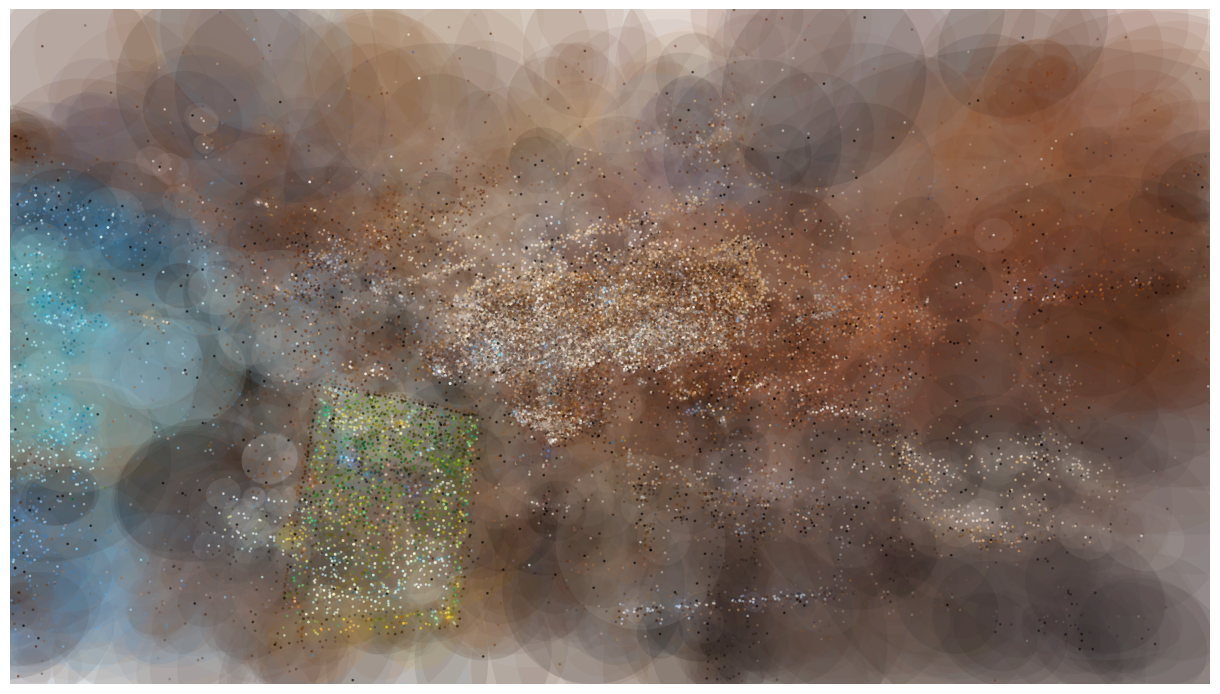

In [31]:
from matplotlib.collections import EllipseCollection

fig, ax = plt.subplots(figsize=(12, 8))

# Calculate angles, widths, and heights for all ellipses at once
angles = np.degrees(np.arctan2(eigenvecs[:, 1, 0], eigenvecs[:, 0, 0]))
widths = 2 * np.sqrt(eigenvals[:, 0])
heights = 2 * np.sqrt(eigenvals[:, 1])

# Create EllipseCollection
ec = EllipseCollection(
    widths, heights, angles,
    units='x',
    offsets=bounded_points,
    transOffset=ax.transData,
    facecolors=bounded_colors,
    alpha=0.1
)
ax.add_collection(ec)

ax.scatter(bounded_points[:, 0], bounded_points[:, 1], 
          c=bounded_colors, s=1, alpha=0.5)

ax.set_aspect('equal')
ax.set_xlim(0, colmap_data.width)
ax.set_ylim(0, colmap_data.height)
ax.axis('off')
plt.gca().set_position([0, 0, 1, 1])  # Remove all padding
plt.savefig('docs/images/projected_gaussian_00001.png', 
            bbox_inches='tight',
            pad_inches=0)  # Remove padding around the plot
plt.show()

In [9]:
# To project covariance to image, apply differentiable tile rasterizer

"""
1. split screen into 16x16 pixel tiles.
2. cull gaussians
 - 99% confidence interval within bounds
 - extreme positions (near and far plane (?)) to avoid unstable 2D covariance
3. instantiate gaussian with hunber of tils they overlap (?)
4. assign each gaussian with key (view space depth, tile ID)
5. Radix sort with GPU (no per-pixel ordering)

6. Accumulate color and alpha from front to back until we reach target saturation (T_alpha)

"""

'\n1. split screen into 16x16 pixel tiles.\n2. cull gaussians\n - 99% confidence interval within bounds\n - extreme positions (near and far plane (?)) to avoid unstable 2D covariance\n3. instantiate gaussian with hunber of tils they overlap (?)\n4. assign each gaussian with key (view space depth, tile ID)\n5. Radix sort with GPU (no per-pixel ordering)\n\n6. Accumulate color and alpha from front to back until we reach target saturation (T_alpha)\n\n'

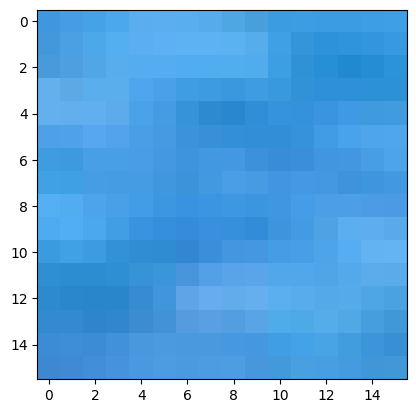

In [15]:
img_name = colmap_data.frame_names[0]
img = plt.imread(f"data/images/{img_name}")
tile = img[:16, :16]
plt.imshow(tile)
plt.show()

In [25]:
# within view frustum, meaning within view frame

In [156]:
# project tile pixel space to 3D space to get view frustum bounds

tile_x1 = 0
tile_x2 = 960
tile_y1 = 0
tile_y2 = 540   
tile_pixels = np.array([[tile_x1, tile_y1], 
                        [tile_x2, tile_y1], 
                        [tile_x1, tile_y2], 
                        [tile_x2, tile_y2]])
tile_pixels = projected_points[0][np.newaxis]

def to_homogeneous(x):
    return np.hstack([x, np.ones((len(x), 1))])

tile_pixels_h = to_homogeneous(tile_pixels)
tile_pixels_cam = (tile_pixels_h @ np.linalg.inv(K).T)
tile_pixels_cam = tile_pixels_cam[:, :3] / tile_pixels_cam[:, 2:]

tile_pixels_world = to_homogeneous(tile_pixels_cam) @ np.linalg.inv(e).T
# tile_pixels_world = tile_pixels_world[:, :3] / tile_pixels_world[:, 2]

In [157]:
tile_pixels_world

array([[ 0.35665332,  1.25977762, -4.11786755,  1.        ]])

In [158]:
points[0]

array([ -8.02574723,   9.80855808, -11.96702985])

In [ ]:
# Gaussians with 99% confidence interval intersecting the view frustum
# so ensure 2 * scale *2.58 or 2* 2.58 * sqrt(diagonal(sigma)) is in view

